<a href="https://colab.research.google.com/github/Prattoypaul/deeplearning/blob/machinel/hate_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator

In [3]:
import re
import scipy
from scipy import sparse
import gc

In [4]:
from IPython.display import display
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import scipy.optimize as optimize
import warnings
warnings.filterwarnings('ignore')


In [5]:
pd.options.display.max_colwidth=300
pd.options.display.max_columns=100

In [6]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/NLP/Hate Speech /Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/NLP/Hate Speech /Dataset/2020-12-31-DynamicallyGeneratedHateDataset-targets-v0.1.csv
/content/drive/MyDrive/Colab Notebooks/NLP/Hate Speech /Dataset/2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv


In [7]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 29.5 MB/s 
     |████████████████████████████████| 106 kB 54.0 MB/s 


In [8]:
import nltk
import contractions
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [10]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Hate Speech /Dataset/2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv")

In [11]:
df.head()

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not question men,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrants can take all the benefits,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [12]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [13]:
df.head()

,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,10003,It was a better world when women dare not question men,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,10004,I don't work this hard so that those immigrants can take all the benefits,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40623 entries, 0 to 40622
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              40623 non-null  object 
 1   text            40623 non-null  object 
 2   label           40623 non-null  object 
 3   type            40623 non-null  object 
 4   model_wrong     26097 non-null  object 
 5   db.model_preds  26097 non-null  float64
 6   status          40623 non-null  object 
 7   round           40623 non-null  object 
 8   split           40623 non-null  object 
 9   annotator       40623 non-null  object 
dtypes: float64(1), object(9)
memory usage: 3.1+ MB


In [15]:
df['id'].dtype

dtype('O')

In [16]:
for i in df.columns:
    print(i,":",df[str(i)].isnull().sum()/df.shape[0])

id : 0.0
text : 0.0
label : 0.0
type : 0.0
model_wrong : 0.35758068089505946
db.model_preds : 0.35758068089505946
status : 0.0
round : 0.0
split : 0.0
annotator : 0.0


In [17]:
df.dropna(axis=0,inplace=True)

In [18]:
for i in df.columns:
  print(i,":",df[str(i)].isnull().sum()/df.shape[0])

id : 0.0
text : 0.0
label : 0.0
type : 0.0
model_wrong : 0.0
db.model_preds : 0.0
status : 0.0
round : 0.0
split : 0.0
annotator : 0.0


In [19]:
df.groupby('type').count()['id']

type
animosity          1121
dehumanization      390
derogation         5377
none              10844
notgiven           7645
support              70
threatening         650
Name: id, dtype: int64

In [20]:
df['type'].nunique()

7

In [21]:
import seaborn as sns

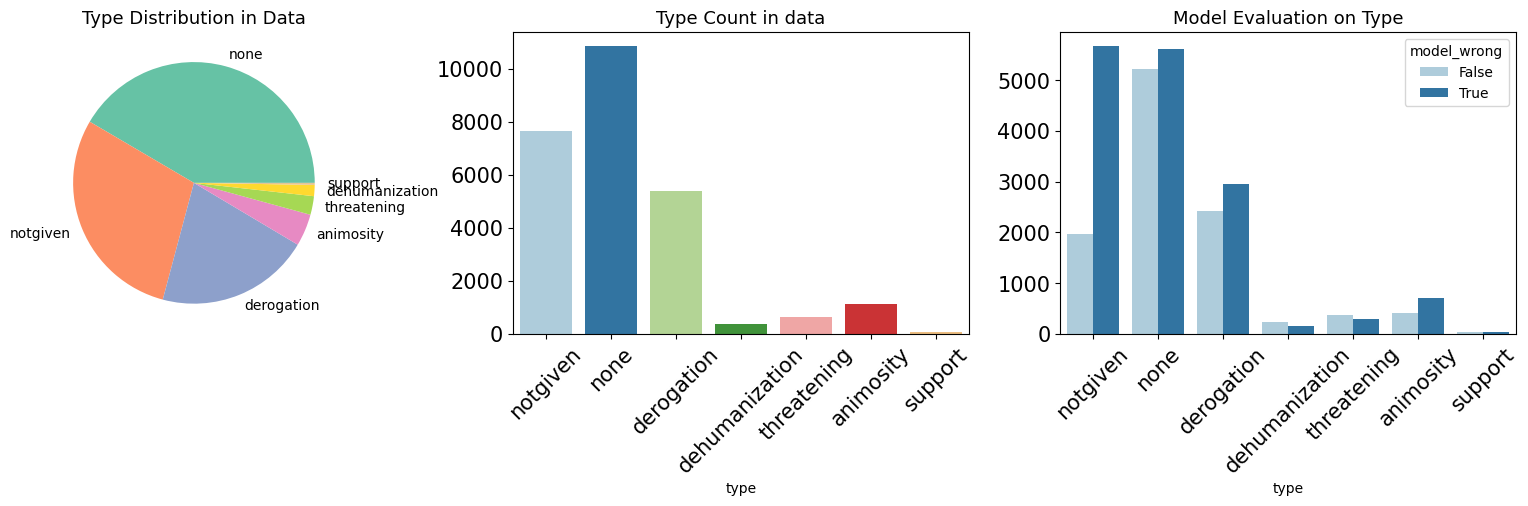

In [22]:
fig,ax=plt.subplots(ncols=3,figsize=(20,4),dpi=100)
colors = ['#66c2a5', '#fc8d62' , '#8da0cb' ,'#e78ac3' , '#a6d854' , '#ffd92f','#e5c494']
df['type'].value_counts().plot(kind='pie',ax=ax[0],labels=df['type'].value_counts().index,colors=colors)
sns.countplot(x='type',data=df,ax=ax[1],palette='Paired')
sns.countplot(x='type',data=df,hue='model_wrong',palette='Paired')


for i in range(3):
  ax[i].set_ylabel(" ")
  ax[i].tick_params(axis='x',labelsize=15,rotation=45)
  ax[i].tick_params(axis='y',labelsize=15)

ax[0].set_title('Type Distribution in Data',fontsize=13)
ax[1].set_title('Type Count in data',fontsize=13)
ax[2].set_title('Model Evaluation on Type',fontsize=13)
plt.show()

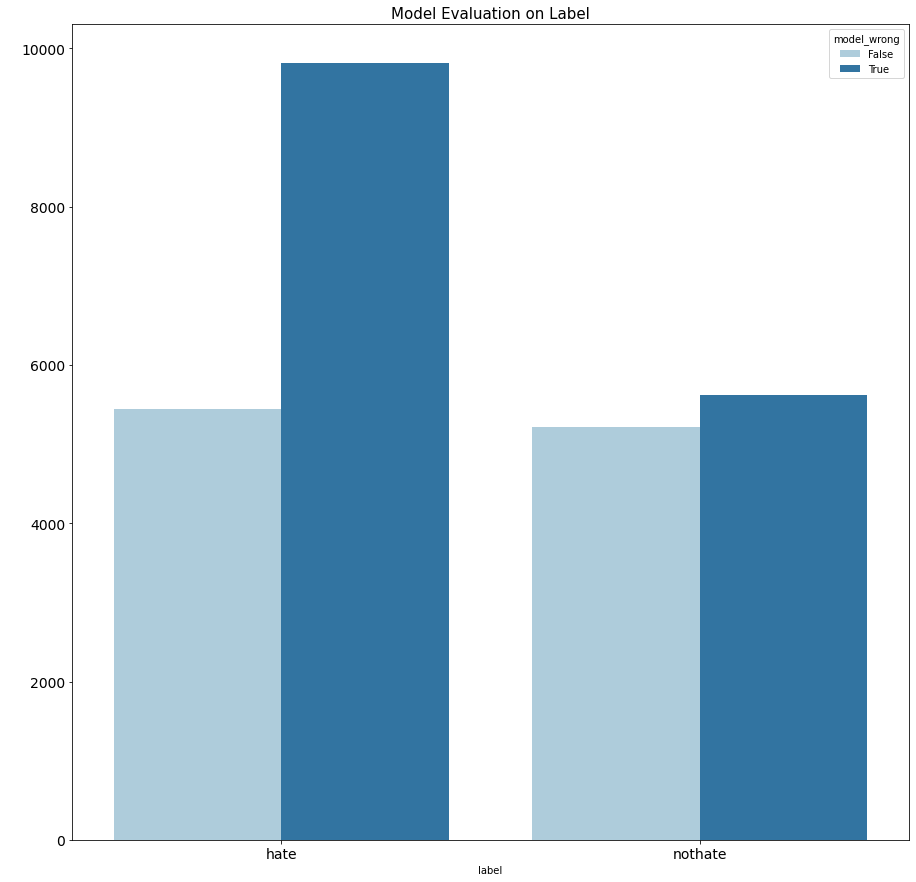

In [23]:
plt.figure(figsize=(15,15))
sns.countplot(x='label',data=df,hue='model_wrong',palette='Paired')
plt.ylabel(" ")
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Model Evaluation on Label",fontsize=15)
plt.show()

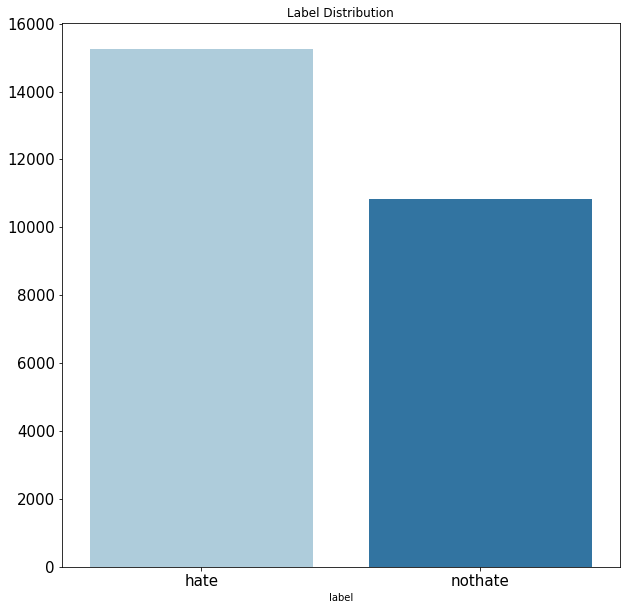

In [24]:
plt.figure(figsize=(10,10))
sns.countplot(x='label',data=df,palette='Paired')
plt.ylabel("")
plt.tick_params(axis='x',labelsize=15)
plt.tick_params(axis='y',labelsize=15)
plt.title("Label Distribution")
plt.show()

In [25]:
def clean_txt(txt):
  Tag_re=re.compile(r'<[^>]+>')
  txt=Tag_re.sub(" ",txt.lower())
  txt=txt.encode('ascii','ignore')
  txt=txt.decode()
  txt=''.join(i for i in txt if not i.isdigit())
  txt=re.sub(r'[^\w\s]', ' ',txt)
  txt=' '.join([i for i in txt.split() if not i in STOPWORDS])
  txt=' '.join([i for i in txt.split() if len(i)>2])
  txt=contractions.fix(txt)
  txt=lemmatizer.lemmatize(txt)
  return txt


In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [27]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [28]:
df['clean_txt']=df['text'].apply(clean_txt)
df.head()

,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator,clean_txt
0,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3,legal husband rape wife
1,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm,dalits lowlife scum
2,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm,dalits lowlives
3,10003,It was a better world when women dare not question men,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3,better world women dare question men
4,10004,I don't work this hard so that those immigrants can take all the benefits,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm,work hard immigrants take benefits


In [29]:
df['model_wrong']=df['model_wrong'].astype('string')
df['model_wrong'].dtype

string[python]

In [30]:
vocab=[ ]
model_wrong=[]
label=[]
for  _ ,row in df.iterrows():
  a=row['clean_txt'].split()
  if(row['label']=='hate'):
    label+=[0 for i in range(len(a))]
  else:
    label+=[1 for i in range(len(a))]
  if(row['model_wrong']=='True'):
    model_wrong+=[0 for  i in range(len(a))]
  else:
    model_wrong+=[1 for i in range(len(a))]
  vocab+=a


In [31]:
vocab_model_relation=pd.DataFrame({'Words':vocab,'Model Wrong': model_wrong,'Label':label})
vocab_model_relation.head()

,Words,Model Wrong,Label
0,legal,0,0
1,husband,0,0
2,rape,0,0
3,wife,0,0
4,dalits,1,0


In [32]:
words=vocab_model_relation[vocab_model_relation['Model Wrong']==1]['Words'].value_counts().index
words

Index(['people', 'black', 'women', 'fucking', 'like', 'love', 'would', 'think',
       'white', 'get',
       ...
       'exported', 'entrenched', 'moisturizer', 'impudence', 'unruliness',
       'petulant', 'functioning', 'argumentativenss', 'cushty', 'shifty'],
      dtype='object', length=12900)

In [33]:
words2=vocab_model_relation[vocab_model_relation['Model Wrong']==0]['Words'].value_counts().index
words2

Index(['people', 'black', 'women', 'fucking', 'like', 'think', 'white', 'want',
       'love', 'everyone',
       ...
       'ideological', 'browned', 'whited', 'sympathise', 'whiting', 'muddling',
       'rub', 'illogicality', 'idealistic', 'unworthy'],
      dtype='object', length=10899)

In [34]:
common_words=list(set(words)&set(words2))
common_words[:10]

['descended',
 'faggots',
 'word',
 'tea',
 'organise',
 'drag',
 'shoot',
 'ending',
 'dirt',
 'iphones']

In [35]:
words=list(set(words).difference(set(common_words)))
words[:10]

['clinicians',
 'webpage',
 'valkyrie',
 'popped',
 'gaaaay',
 'iis',
 'christans',
 'superdykes',
 'promoter',
 'newspiece']

In [36]:
words2=list(set(words2).difference(set(common_words)))
words2[:10]

['psychiatric',
 'modele',
 'snps',
 'unmanageable',
 'fattest',
 'panting',
 'prowess',
 'provision',
 'ciabattas',
 'prob']

In [37]:
from wordcloud import WordCloud

In [38]:
def wc(data,bgcolor,title):
  plt.figure(figsize=(13,10))
  wc=WordCloud(background_color=bgcolor,max_words=1000,max_font_size=50)
  wc.generate(" ".join(data))
  plt.title(title,fontsize=25)
  plt.imshow(wc)
  plt.axis('off')

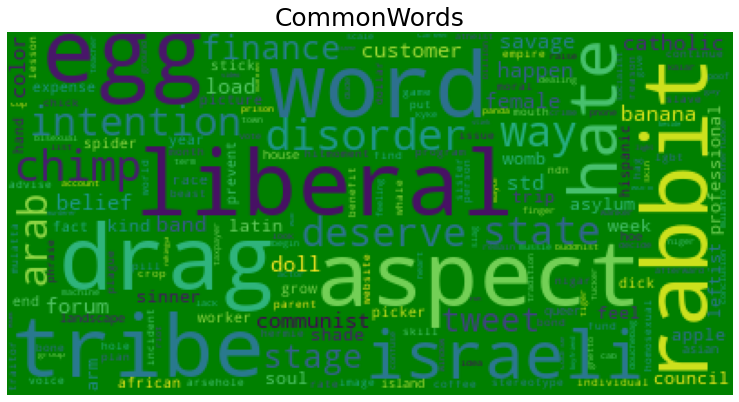

In [39]:
wc(common_words,'green','CommonWords')

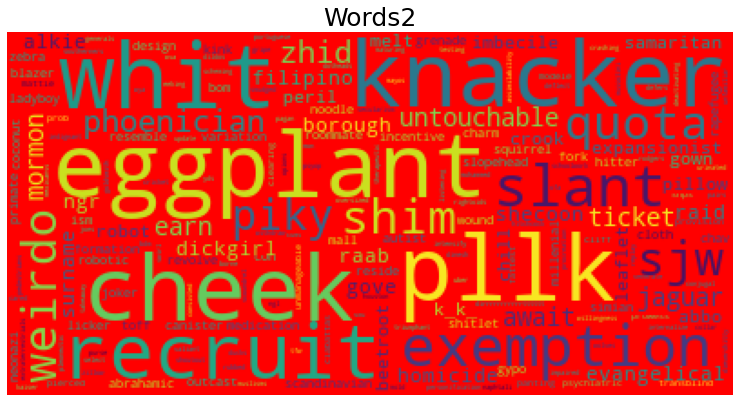

In [40]:
wc(words2,'red','Words2')

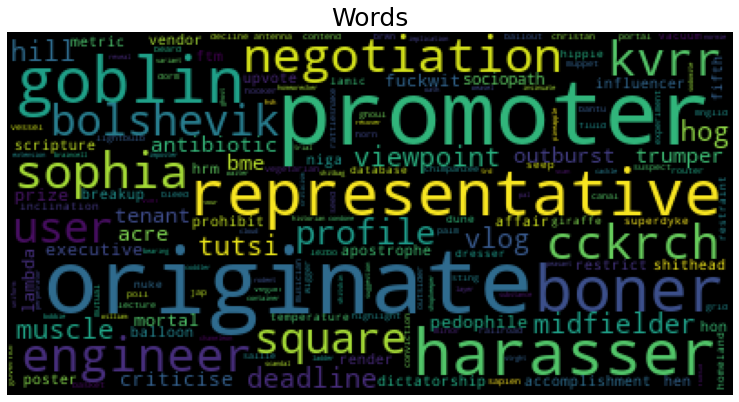

In [41]:
wc(words,'black','Words')

In [42]:
label={'hate':0,'nothate':1}
df['label']=df['label'].map(label)
df.head()

,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator,clean_txt
0,10000,It should be legal for a husband to rape his wife,0,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3,legal husband rape wife
1,10001,dalits are lowlife scum,0,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm,dalits lowlife scum
2,10002,dalits are lowlives,0,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm,dalits lowlives
3,10003,It was a better world when women dare not question men,0,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3,better world women dare question men
4,10004,I don't work this hard so that those immigrants can take all the benefits,0,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm,work hard immigrants take benefits


In [43]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

In [44]:
from sklearn.decomposition import TruncatedSVD ,PCA

In [45]:
x=df['text']
y=df['label']

In [46]:
def cv(data):
  count_vec=CountVectorizer()
  emb=count_vec.fit_transform(data)
  return emb,count_vec

In [47]:
list_corpus=df['text'].tolist()
list_labels=df['label'].tolist()

In [48]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=43)

In [49]:
xtrain_counts,count_vectorizer=cv(xtrain)


In [50]:
xtest_counts=count_vectorizer.transform(xtest)

In [51]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

In [52]:
cvs=CountVectorizer()

In [53]:
xtrain_cv=cvs.fit_transform(xtrain.values)

In [54]:
ytrain[:10]

39369    0
39797    0
579      0
23484    0
39268    1
28846    1
6001     0
33201    0
10524    1
30440    0
Name: label, dtype: int64

In [55]:
xtrain_cv

<20877x15910 sparse matrix of type '<class 'numpy.int64'>'
	with 278495 stored elements in Compressed Sparse Row format>

In [56]:
xtrain_cv.toarray()[:2][0]

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
xtrain_cv.shape

(20877, 15910)

In [58]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(xtrain_cv, ytrain)

MultinomialNB()

In [59]:
xtest_cv=cvs.transform(xtest)

In [60]:
from sklearn.metrics import classification_report

y_pred = model.predict(xtest_cv)

print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3082
           1       0.86      0.80      0.83      2138

    accuracy                           0.87      5220
   macro avg       0.87      0.86      0.86      5220
weighted avg       0.87      0.87      0.87      5220



In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
rfc=RandomForestClassifier()

In [70]:
rfc.fit(xtrain_cv, ytrain)

RandomForestClassifier()

In [71]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(xtest_cv)

print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      3082
           1       0.91      0.80      0.85      2138

    accuracy                           0.89      5220
   macro avg       0.89      0.87      0.88      5220
weighted avg       0.89      0.89      0.88      5220



In [72]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
dtc=DecisionTreeClassifier()

In [74]:
dtc.fit(xtrain_cv,ytrain)

DecisionTreeClassifier()

In [75]:
y_pred = dtc.predict(xtest_cv)

print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3082
           1       0.83      0.80      0.81      2138

    accuracy                           0.85      5220
   macro avg       0.85      0.84      0.84      5220
weighted avg       0.85      0.85      0.85      5220

